# Annotations to OBJECT masks workflow

**Overview:** 

This includes tools to parse annotations from an item (slide) into masks to use in training and evaluating object localization, classification, and segmentation imaging algorithms (eg. MASK-RCNN). Two "versions" of this workflow exist:

- Get labeled mask for any region in a whole-slide image (user-defined)

- Get labeled mask for areas enclosed within special "region-of-interest" (ROI) annotations that have been drawn by the user. This involves mapping annotations (rectangles/polygons) to ROIs and making one mask per ROI.

This extends on some of the workflows described in Amgad et al, 2019:

__Mohamed Amgad, Habiba Elfandy, Hagar Hussein, ..., Jonathan Beezley, Deepak R Chittajallu, David Manthey, David A Gutman, Lee A D Cooper, Structured crowdsourcing enables convolutional segmentation of histology images, Bioinformatics, 2019, btz083__


This slide used as a test example:  

[TCGA-A2-A0YE-01Z-00-DX1](http://candygram.neurology.emory.edu:8080/histomicstk#?image=5d586d57bd4404c6b1f28640&bounds=53566%2C33193%2C68926%2C40593%2C0 )

The user uses a csv file like the one in 
```histomicstk/annotations_and_masks/tests/test_files/sample_GTcodes.csv ```
to control pixel values assigned to mask, overlay order of various annotation groups, which groups are considered to be ROIs, etc. Note that we use the girder definition of term "group" here, which is an annotation style indicating a certain class, such as "tumor" or "necrosis".

**What is the difference between this and `annotations_to_masks_handler`?!**

The difference between this and version 1, found at
histomicstk.annotations_and_masks.annotations_to_masks_handler
is that this (version 2) gets the contours first, including cropping
to wanted ROI boundaries and other processing using shapely, and THEN
parses these into masks. This enables us to differentiate various objects
to use the data for object localization/classification/segmentation
tasks. If you would like to get semantic segmentation masks, i.e. you do
not really care about individual objects, you can use either version 1
or this handler using the `semantic` run mode. 
They re-use much of the same code-base, but some edge cases maybe better handled by version 1. For example, since this version uses shapely first to crop, some objects may be incorrectly parsed by shapely. Version 1, using PIL.ImageDraw may not have these
problems.

Bottom line is: if you need semantic segmentation masks, it is probably
safer to use version 1 (annotations to masks handler), whereas if you need object segmentation masks, this handler should be used in `object` run mode.


**Where to look?**

```
|_ histomicstk/
   |_annotations_and_masks/
      |_annotations_to_object_mask_handler.py 
      |_tests/
         |_annotations_to_object_mask_handler_test.py
         |_test_files/
            |_sample_GTcodes.csv 
```

In [1]:
import os
import sys

import copy
import girder_client
from pandas import DataFrame, read_csv
import tempfile
import shutil
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib inline

from histomicstk.annotations_and_masks.annotation_and_mask_utils import (
    get_bboxes_from_slide_annotations, _get_idxs_for_all_rois,
    scale_slide_annotations, get_scale_factor_and_appendStr)
from histomicstk.annotations_and_masks.annotations_to_object_mask_handler import (
    annotations_to_contours_no_mask, contours_to_labeled_object_mask,
    get_all_rois_from_slide_v2)

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 7, 7
titlesize = 16

/home/mtageld/anaconda3/envs/wsi/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Constants and prepwork

In [2]:
CWD = os.getcwd()

APIURL = 'http://candygram.neurology.emory.edu:8080/api/v1/'
SAMPLE_SLIDE_ID = '5d586d57bd4404c6b1f28640'
GTCODE_PATH = os.path.join(
    CWD, '../../histomicstk/annotations_and_masks/tests/test_files/sample_GTcodes.csv')

# connect to girder client
gc = girder_client.GirderClient(apiUrl=APIURL)
# gc.authenticate(interactive=True)
gc.authenticate(apiKey='kri19nTIGOkWH01TbzRqfohaaDWb6kPecRqGmemb')

# just a temp directory to save masks for now
BASE_SAVEPATH = tempfile.mkdtemp()
SAVEPATHS = {
    'mask': os.path.join(BASE_SAVEPATH, 'masks'),
    'rgb': os.path.join(BASE_SAVEPATH, 'rgbs'),
    'contours': os.path.join(BASE_SAVEPATH, 'contours'),
    'visualization': os.path.join(BASE_SAVEPATH, 'vis'),
}
for _, savepath in SAVEPATHS.items():
    os.mkdir(savepath)
    
# What resolution do we want to get the images at?
# Microns-per-pixel / Magnification (either or)
MPP = 2.5  # <- this roughly translates to 4x magnification
MAG = None

### Let's inspect the ground truth codes file

This contains the ground truth codes and information dataframe.
This is a dataframe that is indexed by the annotation group name and
has the following columns:

- ```group```: group name of annotation (string), eg. "mostly_tumor"
- ```overlay_order```: int, how early to place the annotation in the
    mask. Larger values means this annotation group is overlayed
    last and overwrites whatever overlaps it.
- ```GT_code```: int, desired ground truth code (in the labeled mask)
    Pixels of this value belong to corresponding group (class)
- ```is_roi```: Flag for whether this group marks 'special' annotations that encode the ROI boundary
- ```is_background_class```: Flag, whether this group is the default
    fill value inside the ROI. For example, you may descide that
    any pixel inside the ROI is considered stroma.
    
**IMPORTANT NOTE:** 

Zero pixels have special meaning and do NOT encode specific ground truth class. Instead, they simply
mean 'Outside ROI' and should be IGNORED during model training or evaluation.

In [3]:
# read GTCodes file
GTCodes_dict = read_csv(GTCODE_PATH)
GTCodes_dict.index = GTCodes_dict.loc[:, 'group']
GTCodes_dict = GTCodes_dict.to_dict(orient='index')

In [4]:
GTCodes_dict.keys()

dict_keys(['roi', 'evaluation_roi', 'mostly_tumor', 'mostly_stroma', 'mostly_lymphocytic_infiltrate', 'necrosis_or_debris', 'glandular_secretions', 'mostly_blood', 'exclude', 'metaplasia_NOS', 'mostly_fat', 'mostly_plasma_cells', 'other_immune_infiltrate', 'mostly_mucoid_material', 'normal_acinus_or_duct', 'lymphatics', 'undetermined', 'nerve', 'skin_adnexia', 'blood_vessel', 'angioinvasion', 'mostly_dcis', 'other'])

In [5]:
GTCodes_dict['mostly_tumor']

{'group': 'mostly_tumor',
 'overlay_order': 1,
 'GT_code': 1,
 'is_roi': 0,
 'is_background_class': 0,
 'color': 'rgb(255,0,0)',
 'comments': 'core class'}

## Get region within any bounds (RGB + contours)

### This is the core method you'll want to use

In [6]:
print(annotations_to_contours_no_mask.__doc__)

Process annotations to get RGB and contours without intermediate masks.

    Parameters
    ----------
    gc : object
        girder client object to make requests, for example:
        gc = girder_client.GirderClient(apiUrl = APIURL)
        gc.authenticate(interactive=True)

    slide_id : str
        girder id for item (slide)

    MPP : float or None
        Microns-per-pixel -- best use this as it's more well-defined than
        magnification which is more scanner/manufacturer specific.
        MPP of 0.25 often roughly translates to 40x

    MAG : float or None
        If you prefer to use whatever magnification is reported in slide.
        If neither MPP or MAG is provided, everything is retrieved without
        scaling at base (scan) magnification.

    mode : str
        This specifies which part of the slide to get the mask from. Allowed
        modes include the following
        - wsi: get scaled up/down version of mask of whole slide
        - min_bounding_box: get min

### More input parameters

In [7]:
# common params for annotations_to_contours_no_mask()
annotations_to_contours_kwargs = {
    'MPP': MPP, 'MAG': MAG,
    'linewidth': 0.2,
    'get_rgb': True, 'get_visualization': True,
}

### 1. manual_bounds mode

As you've seen in documentation, this method has four run modes. Here we test the basic 'manual_bounds' mode, where you just ive the boundaries (at base/scan magnification) of the annotations you want. Of course everything will be scaled to the desired resolution. 

In [8]:
bounds = {
    'XMIN': 58000, 'XMAX': 63000,
    'YMIN': 35000, 'YMAX': 39000
}

In [9]:
# get specified region, let the method get and scale annotations
roi_out = annotations_to_contours_no_mask(
    gc=gc, slide_id=SAMPLE_SLIDE_ID,
    mode='manual_bounds', bounds=bounds,
    **annotations_to_contours_kwargs)

/home/mtageld/Desktop/HistomicsTK/histomicstk/annotations_and_masks/annotation_and_mask_utils.py:640: RuntimeWarning: invalid value encountered in greater
  iou = iou[:, iou[1, :] > iou_thresh].astype(int)


The result is an rgb image, contours and a visualization. Let's take a look at these below.

In [10]:
roi_out.keys()

dict_keys(['rgb', 'contours', 'bounds', 'visualization'])

In [11]:
roi_out['bounds']

{'XMIN': 57994, 'XMAX': 62994, 'YMIN': 34999, 'YMAX': 38992}

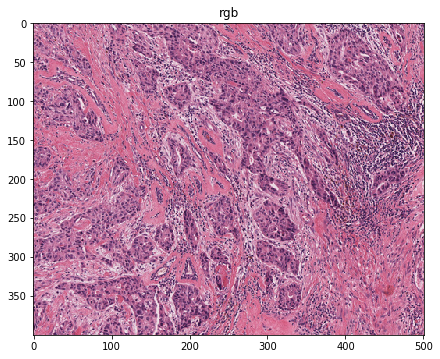

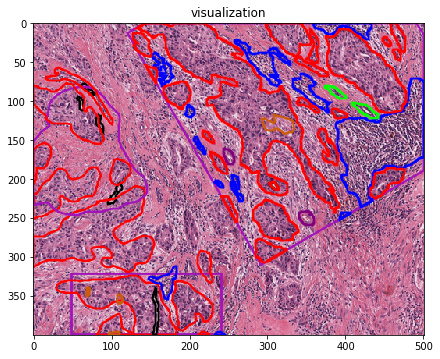

In [12]:
for imstr in ['rgb', 'visualization']:
    plt.imshow(roi_out[imstr])
    plt.title(imstr)
    plt.show()

In [13]:
DataFrame(roi_out['contours']).head()

,annidx,annotation_girder_id,elementidx,element_girder_id,type,group,color,xmin,xmax,ymin,ymax,bbox_area,coords_x,coords_y
0,0,5d586d58bd4404c6b1f28642,0,5a943eb992ca9a0016fae97f,rectangle,roi,"rgb(163, 19, 186)",121,501,0,310,117800,"491,143,121,292,501,501,491","0,0,13,310,189,15,0"
1,1,5d586d58bd4404c6b1f28644,0,5a943eb992ca9a0016fae981,polyline,blood_vessel,"rgb(128,0,128)",341,360,241,259,342,"353,352,351,350,350,349,348,347,346,345,344,34...","241,241,241,241,242,242,242,242,242,242,242,24..."
2,1,5d586d58bd4404c6b1f28644,1,5a943eb992ca9a0016fae982,polyline,blood_vessel,"rgb(128,0,128)",244,258,161,181,280,"244,244,244,244,244,244,245,245,245,245,245,24...","161,162,163,165,166,167,167,168,169,170,171,17..."
3,2,5d586d58bd4404c6b1f2864c,0,5a943eba92ca9a0016fae990,polyline,mostly_lymphocytic_infiltrate,"rgb(0,0,255)",388,501,71,236,18645,"501,501,500,500,499,498,498,497,496,495,495,49...","171,75,75,74,74,74,73,73,72,72,71,71,71,71,72,..."
4,2,5d586d58bd4404c6b1f2864c,1,5a943eba92ca9a0016fae994,polyline,mostly_lymphocytic_infiltrate,"rgb(0,0,255)",359,434,0,21,1575,"434,359,359,359,360,360,360,361,361,362,362,36...","0,0,1,2,2,3,4,5,6,6,7,7,7,7,7,8,8,8,9,9,11,12,..."


Note that if we were to use the above function call repeatedly for the same slide
(eg to get tiles or multiple regions of interest), this would repeatedly use a 
get request to obtain the annotations from the server, which is inefficient. Instead,
if we know we'll be using this repeatedly for the same slide, we manually get annotations
and scale them down/up to desired resolution, and pass them to `annotations_to_contours_no_mask()`
method. Here's how this could be done. 

In [14]:
# get annotations for slide
slide_annotations = gc.get('/annotation/item/' + SAMPLE_SLIDE_ID)

# scale up/down annotations by a factor
sf, _ = get_scale_factor_and_appendStr(
    gc=gc, slide_id=SAMPLE_SLIDE_ID, MPP=MPP, MAG=MAG)
slide_annotations = scale_slide_annotations(slide_annotations, sf=sf)

# get bounding box information for all annotations
element_infos = get_bboxes_from_slide_annotations(slide_annotations)

In [15]:
# get specified region -- manually providing scaled annotations
roi_out = annotations_to_contours_no_mask(
    gc=gc, slide_id=SAMPLE_SLIDE_ID,
    mode='manual_bounds', bounds=bounds,
    slide_annotations=slide_annotations, element_infos=element_infos,
    **annotations_to_contours_kwargs)

In [16]:
roi_out['bounds']

{'XMIN': 57994, 'XMAX': 62994, 'YMIN': 34999, 'YMAX': 38992}

### 2. min_bounding_box mode

If you don't care about any "special" ROI annotations and would just like to parse everything in the
slide into a 'super' minimum-bounding-box labeled mask, use the `min_bounding_box` mode as follows.

In [17]:
# get ROI bounding everything
minbbox_out = annotations_to_contours_no_mask(
    gc=gc, slide_id=SAMPLE_SLIDE_ID,
    mode='min_bounding_box', **annotations_to_contours_kwargs)

In [18]:
minbbox_out['bounds']

{'XMIN': 56726, 'YMIN': 33483, 'XMAX': 63732, 'YMAX': 39890}

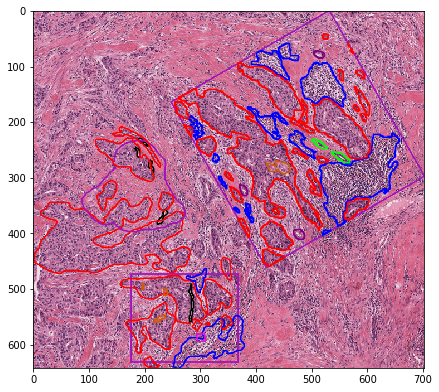

In [19]:
plt.imshow(minbbox_out['visualization'])

### 3. wsi mode
If you just want a miniature version of the slide and all its annotations, use this mode.

WARNING: This does not rely on tiles, but instead fetches an RGB at whatever magnification you want. 
Nevertheless, you can elect to NOT fetch the RGB or the visualization and to just fetch the mask, 
giving you a bigger magnification range before you run out of memory. If you really want to get a
segmentation mask for the whole slide, not just a bounding box, you can use the `manual_bounds`
run mode and tile things yourself using VIPS, for instance. 

In [20]:
# get entire wsi region
get_kwargs = copy.deepcopy(annotations_to_contours_kwargs)
get_kwargs['MPP'] = 5.0  # otherwise it's too large!
wsi_out = annotations_to_contours_no_mask(
    gc=gc, slide_id=SAMPLE_SLIDE_ID,
    mode='wsi', **get_kwargs)

In [21]:
wsi_out['bounds']

{'XMIN': 0, 'XMAX': 131516, 'YMIN': 0, 'YMAX': 80439}

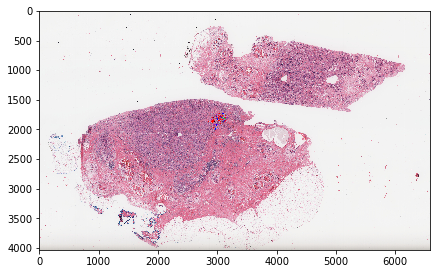

In [22]:
plt.imshow(wsi_out['visualization'])
plt.show()

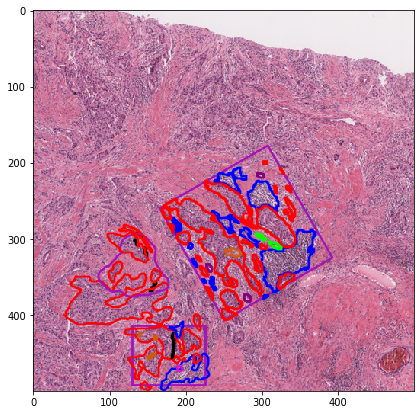

In [23]:
plt.imshow(wsi_out['visualization'][1500:2000, 2800:3300])
plt.show()

## Parse manually-drawn ROIs into separate labeled OBJECT masks

### This is the core method you'll want to use

This utilizes the __polygonal_bounds__ mode of the `get_image_and_mask_from_slide()` method.

In [24]:
print(get_all_rois_from_slide_v2.__doc__)

Get all ROIs for a slide without an intermediate mask form.

    This mainly relies on contours_to_labeled_object_mask(), which should
    be referred to for extra documentation.

    This can be run in either the 'object' mode, whereby the saved masks
    are a three-channel png where first channel encodes class label (i.e.
    same as semantic segmentation) and the product of the values in the
    second and third channel encodes the object ID. Otherwise, the user
    may decide to run in the 'semantic' mode and the resultant mask would
    consist of only one channel (semantic segmentation with no object
    differentiation).

    The difference between this and version 1, found at
    histomicstk.annotations_and_masks.annotations_to_masks_handler.
    get_all_rois_from_slide()
    is that this (version 2) gets the contours first, including cropping
    to wanted ROI boundaries and other processing using shapely, and THEN
    parses these into masks. This enables us to differentiate

The above method mainly relies on `contours_to_labeled_object_mask()`, described below.

In [25]:
print(contours_to_labeled_object_mask.__doc__)

Process contours to get and object segmentation labeled mask.

    Parameters
    ----------
    contours : DataFrame
        contours corresponding to annotation elemeents from the slide.
        All coordinates are relative to the mask that you want to output.
        The following columns are expected.

        group : str
            annotation group (ground truth label).
        ymin : int
            minimun y coordinate
        ymax : int
            maximum y coordinate
        xmin : int
            minimum x coordinate
        xmax : int
            maximum x coordinate
        coords_x : str
            vertix x coordinates comma-separated values
        coords_y
            vertix y coordinated comma-separated values

    gtcodes : DataFrame
        the ground truth codes and information dataframe.
        This is a dataframe that is indexed by the annotation group name and
        has the following columns.

        group: str
            group name of annotation, eg. most

In [26]:
get_all_rois_kwargs = {
    'gc': gc,
    'slide_id': SAMPLE_SLIDE_ID,
    'GTCodes_dict': GTCodes_dict,
    'save_directories': SAVEPATHS,
    'annotations_to_contours_kwargs': annotations_to_contours_kwargs,
    'slide_name': 'TCGA-A2-A0YE',
    'mode': 'object',
    'verbose': True,
    'monitorprefix': 'test',
}
savenames = get_all_rois_from_slide_v2(**get_all_rois_kwargs)

test: roi 1 of 3: Overlay level -1: Element 1 of 50: roi
test: roi 1 of 3: Overlay level 1: Element 2 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 3 of 50: mostly_lymphocytic_infiltrate
test: roi 1 of 3: Overlay level 1: Element 4 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 5 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 6 of 50: mostly_lymphocytic_infiltrate
test: roi 1 of 3: Overlay level 1: Element 7 of 50: mostly_lymphocytic_infiltrate
test: roi 1 of 3: Overlay level 1: Element 8 of 50: mostly_lymphocytic_infiltrate
test: roi 1 of 3: Overlay level 1: Element 9 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 10 of 50: mostly_lymphocytic_infiltrate
test: roi 1 of 3: Overlay level 1: Element 11 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 12 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 13 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 14 of 50: mostly_tumor
test: ro

In [27]:
savenames[0]

{'mask': '/tmp/tmpdecvbm70/masks/TCGA-A2-A0YE_left-59191_top-33483_bottom-63732_right-38083.png',
 'rgb': '/tmp/tmpdecvbm70/rgbs/TCGA-A2-A0YE_left-59191_top-33483_bottom-63732_right-38083.png',
 'visualization': '/tmp/tmpdecvbm70/vis/TCGA-A2-A0YE_left-59191_top-33483_bottom-63732_right-38083.png',
 'contours': '/tmp/tmpdecvbm70/contours/TCGA-A2-A0YE_left-59191_top-33483_bottom-63732_right-38083.csv'}

### Let's visualize the contours

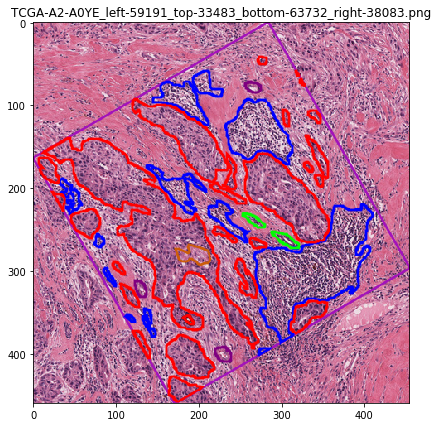

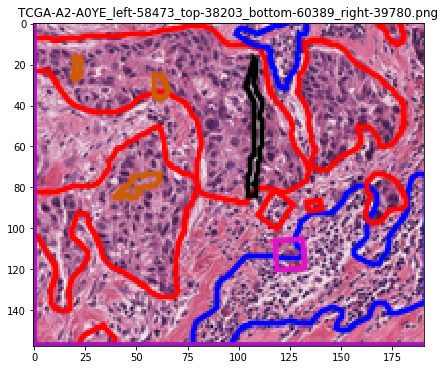

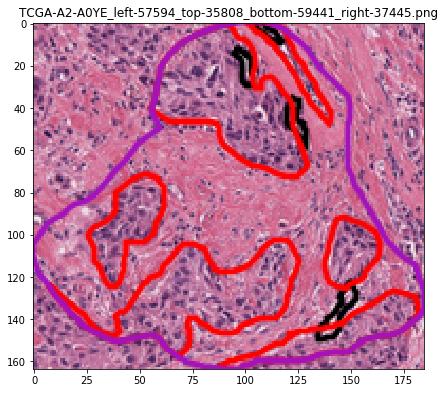

In [28]:
# visualization of contours over RGBs
for savename in savenames:
    vis = imread(savename["visualization"])
    plt.imshow(vis)
    plt.title(os.path.basename(savename["visualization"]))
    plt.show()

### Let's visualize the object mask

we multiply the second and third channel values to get the object ID.

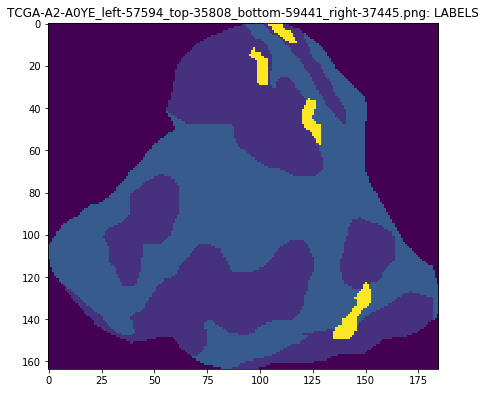

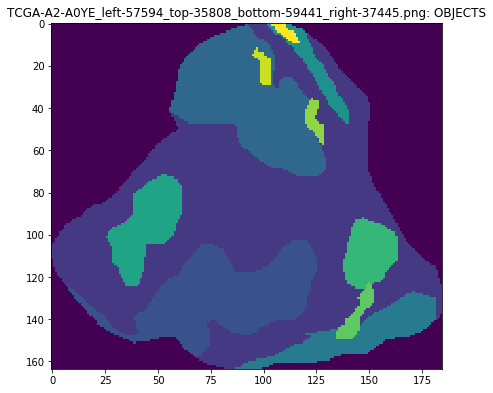

In [29]:
mask = imread(savename["mask"])
maskname = os.path.basename(savename["mask"]) 

plt.imshow(mask[..., 0])
plt.title(maskname + ': LABELS')
plt.show()

plt.imshow(mask[..., 1] * mask[..., 2])
plt.title(maskname + ': OBJECTS')
plt.show()